<a href="https://colab.research.google.com/github/Simurgh818/BMED_6517_emotional_state_classifier/blob/main/EEG_SimpleResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import pickle
import pandas as pd
import numpy as np
import pywt

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

from sklearn.decomposition import FastICA



import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

In [ ]:
#importing our git repo
import os
if not os.path.exists('/content/BMED_6517_emotional_state_classifier'):
  !wget https://github.com/Simurgh818/BMED_6517_emotional_state_classifier/blob/main/requirements.txt -q --show-progress --progress=dot
  !git clone https://github.com/Simurgh818/BMED_6517_emotional_state_classifier.git


     0K .......... .......... .......... .......... .......... 3.40M
    50K .......... .......... .......... .......... .......... 6.91M
   100K .......... .......... .......... .......... .......... 86.5M
   150K .......... .......... ..                                102M=0.02sCloning into 'BMED_6517_emotional_state_classifier'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 139 (delta 6), reused 12 (delta 1), pack-reused 114
Receiving objects: 100% (139/139), 78.37 MiB | 17.44 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [ ]:
#root_folder = 'C:/Users/thiag/OneDrive - Georgia Institute of Technology/DEAP'


npy_folder = os.path.join(os.getcwd(), 'BMED_6517_emotional_state_classifier','results', 'npy')
#feats_folder = os.path.join(os.getcwd(), 'results', 'EEG_features')


#if not os.path.exists(feats_folder):
 #   os.makedirs(feats_folder, exist_ok=True)

# Load Features

In [ ]:

feats_path = os.path.join(npy_folder, 'EEG_features.npy')
print(feats_path)
loaded_features = np.load(feats_path, allow_pickle=True)

connectivityMatrix = loaded_features.item().get('connectivity_matrix')
connectivityLinear = loaded_features.item().get('connectivity_linear')
wavelet = loaded_features.item().get('waveletEntropy')
Valence = loaded_features.item().get('Valence')
Arousal = loaded_features.item().get('Arousal')
Classes = loaded_features.item().get('Classes')

print(connectivityMatrix.shape)
print(connectivityLinear.shape)
print(wavelet.shape)
print(Valence.shape)
print(Arousal.shape)
print(Classes.shape)

/content/BMED_6517_emotional_state_classifier/results/npy/EEG_features.npy
(880, 5, 32, 32)
(880, 5, 512)
(880, 32, 6)
(880,)
(880,)
(880,)


In [ ]:
print(Valence[0:10])
print(Classes[0:10])

[7.71 8.1  8.58 4.94 6.96 8.27 7.44 7.32 4.04 1.99]
[3. 3. 3. 2. 1. 1. 1. 1. 0. 0.]


### Binarization of connectivity matrix

In [ ]:
mean = np.mean(connectivityMatrix)
binaryConnectivity = connectivityMatrix
print(binaryConnectivity.shape)
binaryConnectivity = np.where(connectivityMatrix < mean, 0, 1)
print(binaryConnectivity[0])

(880, 5, 32, 32)
[[[1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]

 [[1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]

 [[1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]

 [[1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]

 [[1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]]


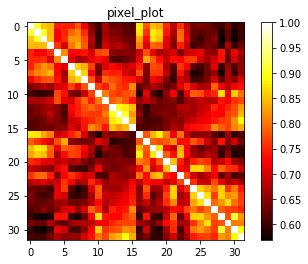

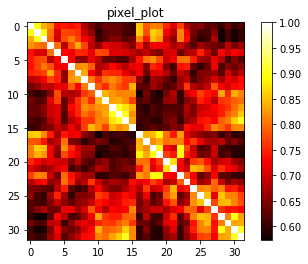

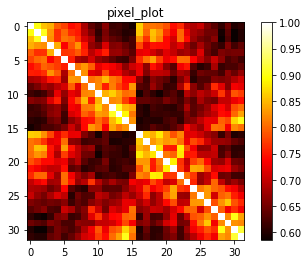

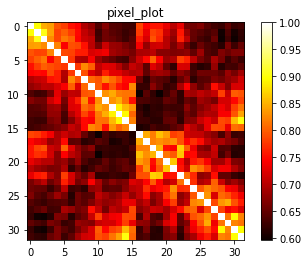

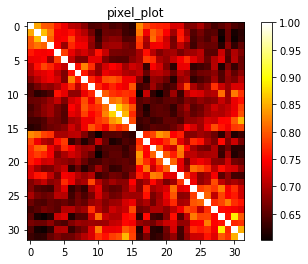

2.0


In [ ]:
epoch = 3
for connectivity_matrix in connectivityMatrix[epoch]:
    pixel_plot = plt.figure()
    pixel_plot.add_axes()
    plt.title("pixel_plot")
    pixel_plot = plt.imshow(connectivity_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar(pixel_plot)
    plt.show(pixel_plot)

print(Classes[epoch])

# Pytorch

In [ ]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
torch.manual_seed(104)

from torch import Tensor
from typing import Type

In [ ]:
x = connectivityMatrix
y = Classes.astype(int)
# y = np.where(Valence < 5, 0, 1)

print(x[:,:,:,:].shape)
xx = x[:,2:5,:,:]
print(xx.shape)

x_train, x_test, y_train, y_test = train_test_split(xx, y, test_size=0.15, random_state=42)
print(len(x_train))
print(len(x_test))
print(y_train[0:9])
print(y_test[0:9])

(880, 5, 32, 32)
(880, 3, 32, 32)
748
132
[2 2 3 0 3 1 0 2 1]
[3 3 2 1 3 3 0 0 3]


In [ ]:
tensor_x_train = torch.Tensor(x_train) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train)
my_train_dataset = data.TensorDataset(tensor_x_train,tensor_y_train) # create your datset

tensor_x_test = torch.Tensor(x_test)
tensor_y_test = torch.Tensor(y_test)
my_test_dataset = data.TensorDataset(tensor_x_test,tensor_y_test) # create your datset

num_epochs = 500
lr = 1e-2
batch_size = 32

train_loader = data.DataLoader(my_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = data.DataLoader(my_test_dataset, batch_size=batch_size, shuffle=True)

print(tensor_y_train[0:10])

tensor([2., 2., 3., 0., 3., 1., 0., 2., 1., 1.])


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)        
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)        
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
def ResNet18():
    return ResNet(ResidualBlock)

In [ ]:
# Utilities
def plot_curves(history):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].plot(range(1, num_epochs+1), history['train_loss'])
#    axes[0].plot(range(1, num_epochs+1), history['test_loss'])
    axes[0].legend(['Train loss curve', 'Validation loss curve'])
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')


    axes[1].plot(range(1, num_epochs+1), history['train_acc'])
    #axes[1].plot(range(1, num_epochs+1), history['test_acc'])
    axes[1].legend(['Train accuracy curve', 'Validation accuracy curve'])
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('accuracy')
    plt.show()

In [ ]:
#Use the ResNet18 on Cifar-10
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os

#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#set hyperparameter
EPOCH = 100
pre_epoch = 0
BATCH_SIZE = 64
LR = 0.01
n_classes = 4

tensor_x_train = torch.Tensor(x_train) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train)
my_train_dataset = data.TensorDataset(tensor_x_train,tensor_y_train) # create your datset

tensor_x_test = torch.Tensor(x_test)
tensor_y_test = torch.Tensor(y_test)
my_test_dataset = data.TensorDataset(tensor_x_test,tensor_y_test) # create your datset

num_epochs = 500
lr = 1e-2
batch_size = 32

trainloader = data.DataLoader(my_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testloader = data.DataLoader(my_test_dataset, batch_size=batch_size, shuffle=True)

print(tensor_y_train[0:10])

#labels in CIFAR10
classes = ('0', '1', '2', '3')

#define ResNet18
net = ResNet18().to(device)

#define loss funtion & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)

cuda
tensor([2., 2., 3., 0., 3., 1., 0., 2., 1., 1.])


In [ ]:
x_train.mean()


0.7252620063491604

In [ ]:
history = {'train_loss': [], 'train_acc': [], 
           'valid_loss': [], 'valid_acc': [],
           'test_loss': [], 'test_acc': [], 'step_loss': []}

#train
for epoch in range(pre_epoch, EPOCH):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        #prepare dataset
        length = len(trainloader)
        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        #forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print ac & loss in each batch
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

        print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% ' 
              % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
    history['train_loss'].append(sum_loss)
    history['train_acc'].append(100 * correct / total)
    
    #get the ac with testdataset in each epoch
    print('Waiting Test...')
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        

        history['test_acc'].append(100 * correct / total)    
        print('Test\'s ac is: %.3f%%' % (100 * correct / total))

print('Train has finished, total epoch is %d' % EPOCH)

# plot_curves(history)


Epoch: 1
[epoch:1, iter:1] Loss: 2.458 | Acc: 0.000% 
[epoch:1, iter:2] Loss: 2.169 | Acc: 15.625% 
[epoch:1, iter:3] Loss: 2.055 | Acc: 15.625% 
[epoch:1, iter:4] Loss: 1.926 | Acc: 16.406% 
[epoch:1, iter:5] Loss: 1.854 | Acc: 17.500% 
[epoch:1, iter:6] Loss: 1.752 | Acc: 22.396% 
[epoch:1, iter:7] Loss: 1.697 | Acc: 24.554% 
[epoch:1, iter:8] Loss: 1.674 | Acc: 25.000% 
[epoch:1, iter:9] Loss: 1.649 | Acc: 25.694% 
[epoch:1, iter:10] Loss: 1.624 | Acc: 26.250% 
[epoch:1, iter:11] Loss: 1.618 | Acc: 27.841% 
[epoch:1, iter:12] Loss: 1.609 | Acc: 28.385% 
[epoch:1, iter:13] Loss: 1.601 | Acc: 27.644% 
[epoch:1, iter:14] Loss: 1.590 | Acc: 27.679% 
[epoch:1, iter:15] Loss: 1.574 | Acc: 27.292% 
[epoch:1, iter:16] Loss: 1.565 | Acc: 27.930% 
[epoch:1, iter:17] Loss: 1.558 | Acc: 29.228% 
[epoch:1, iter:18] Loss: 1.548 | Acc: 29.514% 
[epoch:1, iter:19] Loss: 1.561 | Acc: 29.112% 
[epoch:1, iter:20] Loss: 1.570 | Acc: 28.594% 
[epoch:1, iter:21] Loss: 1.572 | Acc: 28.125% 
[epoch:1, ite